## Attaching script that we will call in this ipynb (DO NOT CALL)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.multiprocessing as mp
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

GAMMA = 0.995
LR = 3e-4
MAX_EPISODES = 2000
UPDATE_INTERVAL = 30
ENV_NAME = "CartPole-v1"
NUM_WORKERS = 4
ENTROPY_BETA = 0.005
GRAD_CLIP = 2
REWARD_SCALE = 0.5
EPSILON_DECAY_RATE = 0.995
MIN_EPSILON = 0.01

class ActorCritic(nn.Module):
    def __init__(self, input_dim=4, output_dim=2):
        super(ActorCritic, self).__init__()
        self.fc1 = nn.Linear(input_dim, 256)
        self.fc2 = nn.Linear(256, 128)
        self.actor = nn.Linear(128, output_dim)
        self.critic = nn.Linear(128, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        action_logits = self.actor(x)
        value = self.critic(x)
        return action_logits, value


class Worker(mp.Process):
    def __init__(self, gnet, optimizer, global_ep, res_queue, name):
        super(Worker, self).__init__()
        self.name = f"worker_{name}"
        self.env = gym.make(ENV_NAME)
        self.g_ep = global_ep
        self.res_queue = res_queue
        self.gnet = gnet
        self.optimizer = optimizer
        self.lnet = ActorCritic(4, 2)

    def run(self):
        total_step = 1
        worker_rewards = []
        epsilon = 1.0
        epsilon_decay = EPSILON_DECAY_RATE
        epsilon_min = MIN_EPSILON
        while self.g_ep.value < MAX_EPISODES:
            state, _ = self.env.reset()
            buffer_s, buffer_a, buffer_r = [], [], []
            ep_r = 0
            episode_length = 0

            while True:
                s_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
                action_logits, _ = self.lnet(s_tensor)
                action_probs = F.softmax(action_logits, dim=-1)
                action = action_probs.multinomial(1).detach()
                action = action.item()

                obs, reward, terminated, truncated, _ = self.env.step(action)
                done = terminated or truncated
                next_state = obs

                buffer_s.append(state)
                buffer_a.append(action)
                buffer_r.append(reward * REWARD_SCALE)

                ep_r += reward
                state = next_state
                episode_length += 1

                epsilon = max(epsilon * epsilon_decay, epsilon_min)

                if total_step % UPDATE_INTERVAL == 0 or done:
                    self.update_global(done, next_state, buffer_s, buffer_a, buffer_r)
                    buffer_s, buffer_a, buffer_r = [], [], []

                if done:
                    with self.g_ep.get_lock():
                        self.g_ep.value += 1
                    self.res_queue.put((self.name, ep_r, episode_length, epsilon))
                    worker_rewards.append(ep_r)
                    break
                total_step += 1


    def update_global(self, done, next_state, bs, ba, br):
        if done:
            R = 0
        else:
            s_ = torch.tensor(next_state, dtype=torch.float32).unsqueeze(0)
            _, v = self.lnet(s_)
            R = v.item()

        buffer_v_target = []
        for r in reversed(br):
            R = r + GAMMA * R
            buffer_v_target.append(R)
        buffer_v_target.reverse()

        loss = self.compute_loss(bs, ba, buffer_v_target)

        self.optimizer.zero_grad()
        loss.backward()

        nn.utils.clip_grad_norm_(self.lnet.parameters(), GRAD_CLIP)

        for lp, gp in zip(self.lnet.parameters(), self.gnet.parameters()):
            if gp.grad is None:
                gp._grad = lp.grad
            else:
                gp._grad += lp.grad
        self.optimizer.step()
        self.lnet.load_state_dict(self.gnet.state_dict())

    def compute_loss(self, states, actions, targets):
        s = torch.tensor(states, dtype=torch.float32)
        a = torch.tensor(actions, dtype=torch.int64)
        t = torch.tensor(targets, dtype=torch.float32)

        action_logits, values = self.lnet(s)
        log_probs = F.log_softmax(action_logits, dim=-1).gather(1, a.view(-1, 1))
        entropy = -torch.sum(F.softmax(action_logits, dim=-1) * F.log_softmax(action_logits, dim=-1), dim=-1).mean()

        advantage = t - values.squeeze()
        actor_loss = -(log_probs.squeeze() * advantage.detach()).mean()
        critic_loss = F.mse_loss(values.squeeze(), t)
        return actor_loss + 0.5 * critic_loss - ENTROPY_BETA * entropy


def train():
    gnet = ActorCritic(4, 2)
    gnet.share_memory()
    optimizer = torch.optim.Adam(gnet.parameters(), lr=LR)
    global_ep = mp.Value('i', 0)
    res_queue = mp.Queue()

    workers = [Worker(gnet, optimizer, global_ep, res_queue, i) for i in range(NUM_WORKERS)]
    [w.start() for w in workers]

    rewards = []
    episode_lengths = []
    epsilon_values = []
    worker_rewards = {f'worker_{i}': [] for i in range(NUM_WORKERS)}
    episode = 0
    while True:
        msg = res_queue.get()
        if msg is not None:
            worker_name, r, episode_length, epsilon = msg
            rewards.append(r)
            episode_lengths.append(episode_length)
            epsilon_values.append(epsilon)
            worker_rewards[worker_name].append(r)
            if (episode + 1) % 10 == 0:
                print(f"Episode {episode} finished with reward: {r:.2f} and episode length: {episode_length}")
                print(f"[{worker_name}] Episode {episode + 1}/{MAX_EPISODES} | Reward: {r:.2f} | Episode Length: {episode_length}")
            episode += 1
        if global_ep.value >= MAX_EPISODES:
            break

    [w.join() for w in workers]

    plt.figure(figsize=(10, 4))
    plt.plot(rewards)
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.title("A3C on CartPole-v1")
    plt.grid(True)
    plt.savefig('cartpole_a3c_rewards.png')

    plt.figure(figsize=(10, 4))
    plt.plot(episode_lengths)
    plt.xlabel("Episode")
    plt.ylabel("Episode Length")
    plt.title("Episode Length over Time")
    plt.grid(True)
    plt.savefig('cartpole_episode_length.png')

    plt.figure(figsize=(10, 4))
    for worker, worker_rewards in worker_rewards.items():
        plt.plot(worker_rewards, label=worker)
    plt.xlabel("Episode")
    plt.ylabel("Reward")
    plt.title("Rewards per Worker")
    plt.legend()
    plt.grid(True)
    plt.savefig('cartpole_rewards_per_worker.png')

    plt.figure(figsize=(10, 4))
    plt.plot(epsilon_values)
    plt.xlabel("Episode")
    plt.ylabel("Epsilon")
    plt.title("Epsilon Decay Over Time")
    plt.grid(True)
    plt.savefig('cartpole_epsilon_decay.png')

    plt.show()

    torch.save(gnet.state_dict(), "cartpole_a3c_model.pth")

    return gnet

if __name__ == "__main__":
    train()

## Executing external python code (jupyter poses problems running multithreaded environments)

In [15]:
!python task2_3.py

Episode 9 finished with reward: 20.00 and episode length: 20
[worker_0] Episode 10/2000 | Reward: 20.00 | Episode Length: 20
Episode 19 finished with reward: 24.00 and episode length: 24
[worker_3] Episode 20/2000 | Reward: 24.00 | Episode Length: 24
Episode 29 finished with reward: 43.00 and episode length: 43
[worker_1] Episode 30/2000 | Reward: 43.00 | Episode Length: 43
Episode 39 finished with reward: 11.00 and episode length: 11
[worker_2] Episode 40/2000 | Reward: 11.00 | Episode Length: 11
Episode 49 finished with reward: 12.00 and episode length: 12
[worker_3] Episode 50/2000 | Reward: 12.00 | Episode Length: 12
Episode 59 finished with reward: 15.00 and episode length: 15
[worker_0] Episode 60/2000 | Reward: 15.00 | Episode Length: 15
Episode 69 finished with reward: 18.00 and episode length: 18
[worker_3] Episode 70/2000 | Reward: 18.00 | Episode Length: 18
Episode 79 finished with reward: 20.00 and episode length: 20
[worker_1] Episode 80/2000 | Reward: 20.00 | Episode Leng

## Loading plotted graphs from local

In [23]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def load_and_plot(file_name):
    img = mpimg.imread(file_name)
    plt.figure(figsize=(10, 4))
    plt.imshow(img)
    plt.axis('off')
    plt.show()

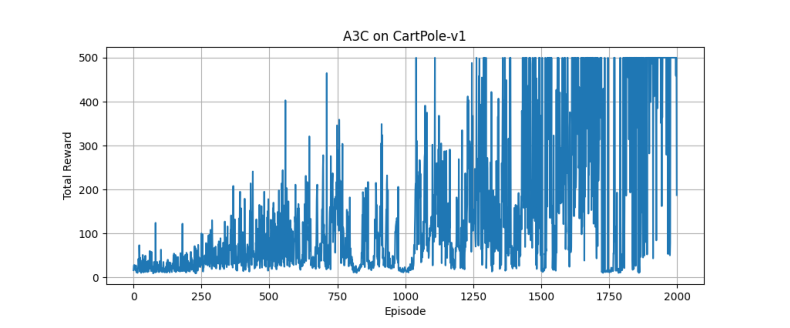

In [24]:
load_and_plot('cartpole_a3c_rewards.png')

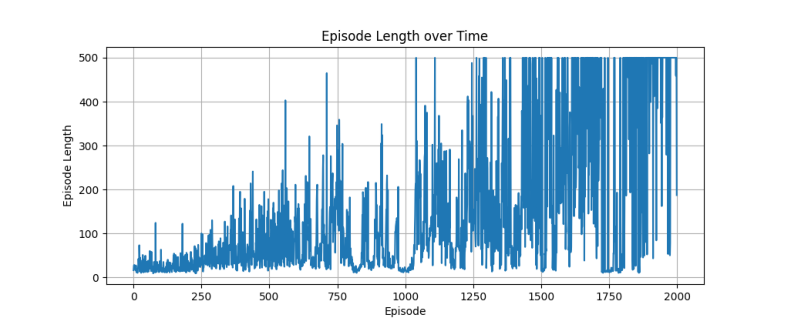

In [25]:
load_and_plot('cartpole_episode_length.png')

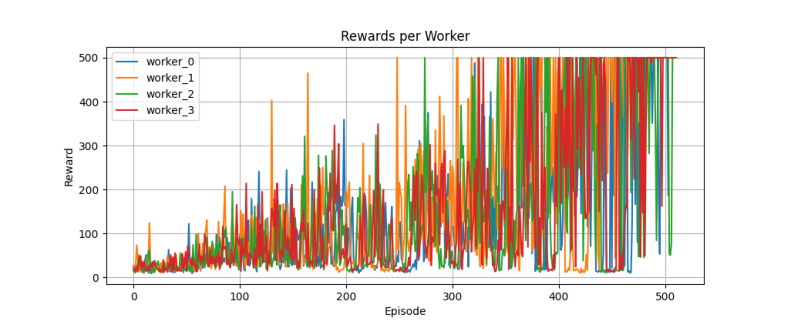

In [26]:
load_and_plot('cartpole_rewards_per_worker.png')

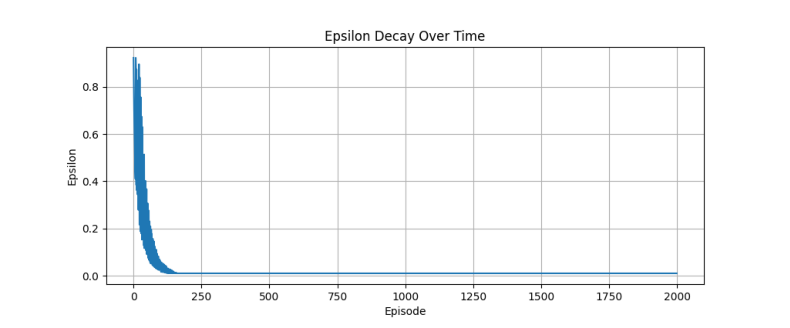

In [27]:
load_and_plot('cartpole_epsilon_decay.png')

## Evaluation

In [3]:
import torch
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.nn as nn

class ActorCritic(nn.Module):
    def __init__(self, input_dim=4, output_dim=2): 
        super(ActorCritic, self).__init__()
        self.fc1 = nn.Linear(input_dim, 256)
        self.fc2 = nn.Linear(256, 128) 
        self.actor = nn.Linear(128, output_dim)
        self.critic = nn.Linear(128, 1) 

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x)) 
        action_logits = self.actor(x)
        value = self.critic(x)
        return action_logits, value

def load_model(model_path="cartpole_a3c_model.pth"):
    model = ActorCritic(4, 2)
    model.load_state_dict(torch.load(model_path))
    model.eval()
    return model

def evaluate(model, num_episodes=10):
    env = gym.make('CartPole-v1')
    eval_rewards = []

    for ep in range(num_episodes):
        obs, _ = env.reset()  
        state = obs
        done = False
        total_reward = 0

        while not done:
            s_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0) 
            with torch.no_grad():
                action_logits, _ = model(s_tensor)
                action_probs = F.softmax(action_logits, dim=-1)
                action = action_probs.argmax(dim=-1).item()

            obs, reward, terminated, truncated, _ = env.step(action) 
            done = terminated or truncated
            state = obs
            total_reward += reward

        eval_rewards.append(total_reward) 
        print(f"[Eval] Episode {ep+1}/{num_episodes} | Reward: {total_reward:.2f}")

    plt.figure(figsize=(10, 4))
    plt.plot(eval_rewards, marker='o')
    plt.xlabel("Evaluation Episode")
    plt.ylabel("Total Reward")
    plt.title("Greedy Evaluation on CartPole-v1")
    plt.grid(True)
    plt.show()

    avg_eval_reward = np.mean(eval_rewards)
    print(f"Average Reward across {num_episodes} episodes : {avg_eval_reward:.2f}")

    if avg_eval_reward > 475:
        print("Environemt Solved!!")

    return eval_rewards

/var/folders/5p/h0g4nrnj5fq_k9bbfh1drssh0000gn/T/ipykernel_91369/1592397211.py:25: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path)

[Eval] Episode 1/50 | Reward: 500.00
[Eval] Episode 2/50 | Reward: 500.00
[Eval] Episode 3/50 | Reward: 500.00
[Eval] Episode 4/50 | Reward: 500.00
[Eval] Episode 5/50 | Reward: 500.00
[Eval] Episode 6/50 | Reward: 500.00
[Eval] Episode 7/50 | Reward: 500.00
[Eval] Episode 8/50 | Reward: 500.00
[Eval] Episode 9/50 | Reward: 500.00
[Eval] Episode 10/50 | Reward: 500.00
[Eval] Episode 11/50 | Reward: 500.00
[Eval] Episode 12/50 | Reward: 500.00
[Eval] Episode 13/50 | Reward: 500.00
[Eval] Episode 14/50 | Reward: 500.00
[Eval] Episode 15/50 | Reward: 500.00
[Eval] Episode 16/50 | Reward: 500.00
[Eval] Episode 17/50 | Reward: 500.00
[Eval] Episode 18/50 | Reward: 500.00
[Eval] Episode 19/50 | Reward: 500.00
[Eval] Episode 20/50 | Reward: 500.00
[Eval] Episode 21/50 | Reward: 500.00
[Eval] Episode 22/50 | Reward: 500.00
[Eval] Episode 23/50 | Reward: 500.00
[Eval] Episode 24/50 | Reward: 500.00
[Eval] Episode 25/50 | Reward: 500.00
[Eval] Episode 26/50 | Reward: 500.00
[Eval] Episode 27/50 

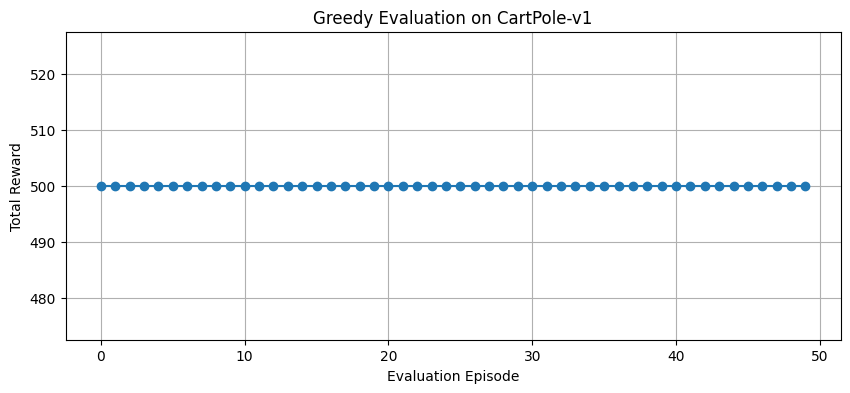

Average Reward across 50 episodes : 500.00
Environemt Solved!!


In [29]:
#loading saved model
model = load_model("cartpole_a3c_model.pth")
evaluate(model,num_episodes=50) 

## Simulation

In [4]:
model = load_model("cartpole_a3c_model.pth")

env = gym.make("CartPole-v1", render_mode="rgb_array")
env = gym.wrappers.RecordVideo(env, video_folder="video_output2", episode_trigger=lambda x: True, name_prefix="cartpole")
state, _ = env.reset()

done = False
total_reward = 0

while not done:
    state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
    action_logits, _ = model(state_tensor)
    action_probs = F.softmax(action_logits, dim=-1)
    action = action_probs.multinomial(1).item() 

    next_state, reward, terminated, truncated, _ = env.step(action)
    done = terminated or truncated
    state = next_state
    total_reward += reward

    env.render() 

print(f"Total Reward for the episode: {total_reward}")

env.close() 

/var/folders/5p/h0g4nrnj5fq_k9bbfh1drssh0000gn/T/ipykernel_21690/1518334970.py:25: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path)

Total Reward for the episode: 500.0
